# Before running this notebook

This notebook requires the SEM to run ns-3 simulations. If you are running this from Binder, SEM should come pre-installed. 

If you are running locally, the SEM library can be installed issuing the following command:
```bash
pip3 install --user https://github.com/signetlabdei/sem/archive/develop.zip
```
Alternatively, uncomment and execute the line below to execute the above command directly from here:

In [1]:
#!pip3 install --user https://github.com/signetlabdei/sem/archive/develop.zip

In [2]:
# Standard imports
import copy
import seaborn as sns
import numpy as np
import pandas as pd
import xarray as xr
from itertools import product
from multiprocessing import Pool

# Load the code to manage results from simulations and the analytical model
from simulation import *
from model import *
from parsingfunctions import *

# Matplotlib tricks to get good quality images 
import matplotlib
matplotlib.rc('lines', **{'linewidth': 2, 'mew': 2})
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})
matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
from cycler import cycler
monochrome = cycler('linestyle', ['solid', 'dashed', '-.', 'dotted', (0, (3, 5, 1, 5, 1, 5))]) + cycler('color', plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])
plt.gca().set_prop_cycle(monochrome)
monochrome_markers = cycler('linestyle', ["None"]) * cycler('marker', ['x', 'o', 'd', '+', 'P']) + cycler('color', plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])
plt.gca().set_prop_cycle(monochrome_markers)

# Single-User Communications

This preliminary result is used to ensure model and simulation are giving similar results for non-OFDMA communications.

Running simulations: 100%|██████████| 450/450 [1:57:43<00:00, 15.70s/simulation]  


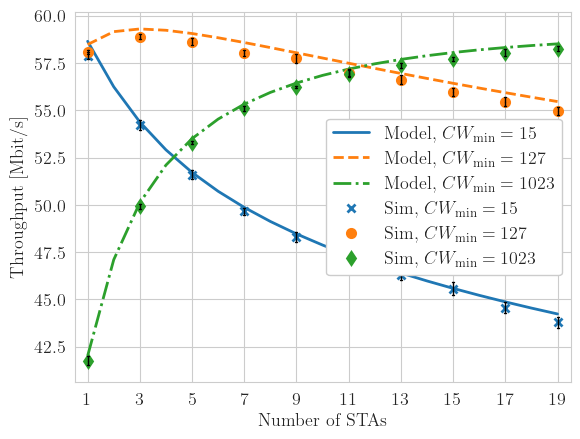

In [3]:
validation_params_model = {
    'nStations': list(range(1, 20)),
    'legacyFraction': [0],
    'frameSize': [1000],
    'channelWidth': [20],
    'Na': [256],
    'cwMin': [15, 127, 1023],
    'mcs': [5],
    'dl': ['su'],
    'ul': ['su'],
    'maxTxopDuration': [4800],
    'ackSeqType': ['AGGR-MU-BAR'],
    'scheduler': ['rr']
}
model_results = get_model_throughput(validation_params_model)
runs = 20
validation_params_sim = adapt_dictionary_for_sims(validation_params_model, step=2, simulationTime=5)
sim_results = get_simulation_metrics(validation_params_sim, runs=runs, overwrite=False, results_folder='ofdma-validation-results')
plt.gca().set_prop_cycle(monochrome)
model_results.sel(metrics=['dl', 'ul']).sum('metrics').squeeze().plot.line(x='nStations')
plt.gca().set_prop_cycle(monochrome_markers)
sim_results.sel(metrics=['dl', 'ul']).sum('metrics').mean('runs').squeeze().plot.line(x='nStations')
plt.gca().set_prop_cycle(monochrome_markers)
plot_with_cis(sim_results.sel(metrics=['dl', 'ul']).sum('metrics'), runs, 'nStations')
plt.title("")
plt.xlabel("Number of STAs")
plt.ylabel("Throughput [Mbit/s]")
plt.xticks(validation_params_sim['nStations'])
plt.legend([r"Model, $CW_{\rm min} = 15$",
            r"Model, $CW_{\rm min} = 127$",
            r"Model, $CW_{\rm min} = 1023$",
            r"Sim, $CW_{\rm min} = 15$",
            r"Sim, $CW_{\rm min} = 127$",
            r"Sim, $CW_{\rm min} = 1023$"],
           framealpha=1)
plt.grid(True, axis='both', which='both')
plt.savefig('figures/suonly.pdf', bbox_inches='tight')
plt.show()

# Testing Schedulers

## Throughput

Running simulations: 100%|██████████| 270/270 [36:01<00:00,  8.00s/simulation] 


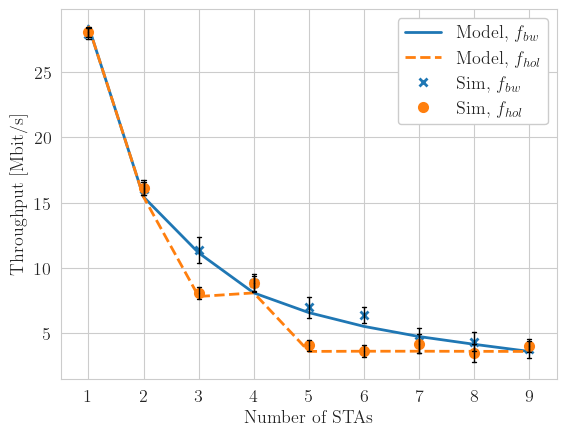

In [4]:
validation_params_model = {
    'nStations': list(range(1, 10)),
    'legacyFraction': [0],
    'frameSize': [1000],
    'channelWidth': [20],
    'Na': [256],
    'cwMin': [15],
    'mcs': [5],
    'dl': ['mu'],
    'ul': ['su'],
    'maxTxopDuration': [4800],
    'ackSeqType': ['AGGR-MU-BAR'],
    'scheduler': ['rr', 'bellalta']
}
model_output = get_model_throughput(validation_params_model).squeeze()
plt.gca().set_prop_cycle(monochrome)
model_output.sel(metrics='dl').squeeze().plot.line(x='nStations')
runs = 20
validation_params_sim = adapt_dictionary_for_sims(validation_params_model, step=1, simulationTime=5)
sim_results = get_simulation_metrics(validation_params_sim, runs=runs, overwrite=False, results_folder='ofdma-validation-results')
plt.gca().set_prop_cycle(monochrome_markers)
sim_results.sel(metrics='dl').mean('runs').squeeze().plot.line(x='nStations')
plot_with_cis(sim_results.sel(metrics='dl'), runs, 'nStations')
plt.title("")
plt.xlabel("Number of STAs")
plt.ylabel("Throughput [Mbit/s]")
plt.xticks(validation_params_sim['nStations'])
plt.legend([
    r"Model, $f_{bw}$",
    r"Model, $f_{hol}$",
    r"Sim, $f_{bw}$",
    r"Sim, $f_{hol}$",
            ], framealpha=1)
plt.grid(True, axis='both', which='both')
plt.savefig('figures/schedulers.pdf', bbox_inches='tight')
plt.show()

## Head-of-Line Delay

Running model: 100%|██████████| 18/18 [00:00<00:00, 19564.00Parameter combination/s]


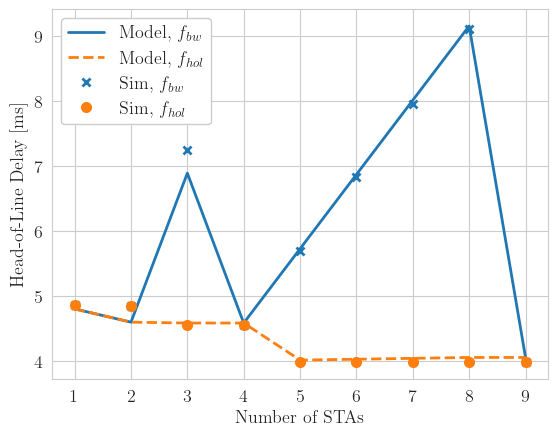

In [5]:
validation_params_model = {
    'nStations': list(range(1, 10)),
    'legacyFraction': [0],
    'frameSize': [1000],
    'channelWidth': [20],
    'Na': [256],
    'cwMin': [15],
    'mcs': [5],
    'dl': ['mu'],
    'ul': ['None'],
    'maxTxopDuration': [4800],
    'ackSeqType': ['AGGR-MU-BAR'],
    'scheduler': ['rr', 'bellalta']
}
model_output = get_model_throughput(validation_params_model).squeeze()
plt.gca().set_prop_cycle(monochrome)
model_output.sel(metrics='hol').squeeze().plot.line(x='nStations')
runs = 2
validation_params_sim = adapt_dictionary_for_sims(validation_params_model, step=1, simulationTime=5)
sim_results = get_simulation_metrics(validation_params_sim, runs=runs, overwrite=False, results_folder='ofdma-validation-results')
plt.gca().set_prop_cycle(monochrome_markers)
sim_results.sel(metrics='hol').mean('runs').squeeze().plot.line(x='nStations')
plt.title("")
plt.xlabel("Number of STAs")
plt.ylabel("Head-of-Line Delay [ms]")
plt.xticks(validation_params_sim['nStations'])
plt.legend([
    r"Model, $f_{bw}$",
    r"Model, $f_{hol}$",
    r"Sim, $f_{bw}$",
    r"Sim, $f_{hol}$",
    ], framealpha=1)
plt.grid(True, axis='both', which='both')
plt.savefig('figures/schedulers_hol.pdf', bbox_inches='tight')
plt.show()

# ACK Sequences

Running model: 100%|██████████| 114/114 [00:00<00:00, 41095.89Parameter combination/s]


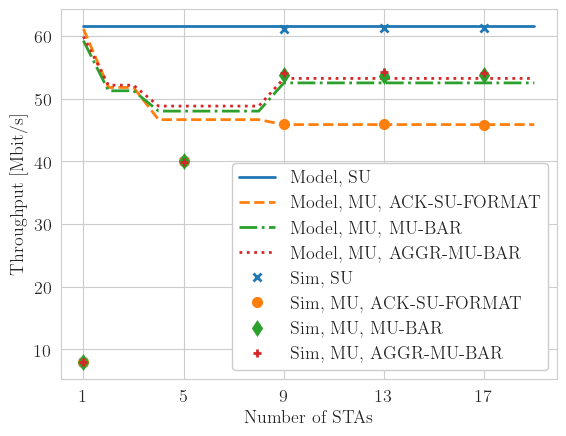

In [6]:
validation_params_model = {
    'nStations': list(range(1, 20)),
    'legacyFraction': [0],
    'frameSize': [1000],
    'channelWidth': [20],
    'Na': [256],
    'cwMin': [15],
    'mcs': [5],
    'dl': ['su', 'mu'],
    'ul': ['None'],
    'maxTxopDuration': [4800],
    'ackSeqType': ['ACK-SU-FORMAT', 'MU-BAR', 'AGGR-MU-BAR'],
    'scheduler': ['rr'],
}
model_output = get_model_throughput(validation_params_model)
plt.gca().set_prop_cycle(monochrome)
model_output.sel(metrics='dl', dl='su',
                 ackSeqType='ACK-SU-FORMAT').squeeze().plot.line(x='nStations')
model_output.sel(metrics='dl', dl='mu').squeeze().plot.line(x='nStations')
plt.gca().set_prop_cycle(monochrome_markers)
runs = 2
# SU
validation_params_sim = adapt_dictionary_for_sims(validation_params_model, step=4)
validation_params_sim['dl'] = ['su']
validation_params_sim['ackSeqType'] = ['NO-OFDMA']
validation_params_sim['dlFlowDataRate'] = [1]
validation_params_sim['ulFlowDataRate'] = [1]
sim_results = get_simulation_metrics(validation_params_sim, runs=runs, overwrite=False, results_folder='ofdma-validation-results')
sim_results.sel(metrics='dl').mean('runs').squeeze().plot.line('x', x='nStations')
# MU
validation_params_sim['dl'] = ['mu']
validation_params_sim['ackSeqType'] = ['ACK-SU-FORMAT', 'MU-BAR', 'AGGR-MU-BAR']
sim_results = get_simulation_metrics(validation_params_sim, runs=runs, overwrite=False, results_folder='ofdma-validation-results')
sim_results.sel(metrics='dl').mean('runs').squeeze().plot.line(x='nStations')
plt.title("")
plt.legend([
    r"Model, SU",
    r"Model, MU, ACK-SU-FORMAT",
    r"Model, MU, MU-BAR",
    r"Model, MU, AGGR-MU-BAR",
    r"Sim, SU",
    r"Sim, MU, ACK-SU-FORMAT",
    r"Sim, MU, MU-BAR",
    r"Sim, MU, AGGR-MU-BAR",
], framealpha=1)
plt.grid('both')
plt.xlabel("Number of STAs")
plt.ylabel("Throughput [Mbit/s]")
plt.xticks(validation_params_sim['nStations'])
plt.savefig('figures/acksequences.pdf', bbox_inches='tight')
plt.show()

# Copy figures to another folder

Remove the heading # from the following cell to copy the generated figures to another folder (for instance, the paper's figures folder).

In [7]:
#!cp figures/* path_to_paper_figures 